## Assessment of Dataset and Database Management System
In this analysis, we perform quick analysis of our dataset and prototyping of which DBMS to use for our final project. We decided to use PostgreSQL because it is stable and reliable. We also studied two secure methods, SQLAlchemy and Psycopg2, that allow Python code to connect to PostgreSQL and effectively execute query commands in a database session.

Both SQLAlchemy and Psycopg2 provide secure and reliable connections with SQL databases, including PostgreSQL and MySQL, and are actively maintained. Our team decided to use:

- Dataset: Churn rate of bank customers' involvement history.
- DBMS: PostgreSQL.
- SQLAlchemy: SQL Toolkit and Object Relational Mapper (ORM), which provides a reliable and comprehensive set of tools for working with databases and Python.
- Supervised ML: Ensemble Learning Algorithms.

Three ensemble learning models, `BalancedRandomForestClassifier`, `EasyEnsembleClassifier`, and `AdaBoostClassifier`, were studied and compared to predict churn rate of customers based on bank customers' involvement. Scaling was skipped because Random Forests and Decision Trees are based on tree partitioning algorithms.

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.schema import CreateTable, DropTable, CreateColumn

# Import postgres pass
import os
from dotenv import load_dotenv
load_dotenv('../../.env')
pga_pass = os.getenv('PGA_PASS')

In [2]:
# Dependencies for ML
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf

In [346]:
# Read the data into a Pandas DataFrame
df = pd.read_csv('./Resources/Churn_Modelling_2.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [347]:
# drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [348]:
# check null values
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [349]:
# check number of duplicates
df.duplicated().sum()

0

In [350]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [351]:
# Determine the number of unique values in each column.
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [352]:
bins = [18, 28, 38, 48, 58, 68, 92]
age_grps = ['18-28', '28-38', '38-48', '48-58', '58-68', '68-92']
df['AgeGroup'] = pd.cut(df['Age'], bins, labels=age_grps, right=False).astype('object')
df = df.drop(['Age'], axis=1)
df.sample(10)

,CreditScore,Geography,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
7878,731,France,Female,10,123711.73,2,1,0,171340.68,1,38-48
5807,679,France,Female,9,112528.65,2,1,0,177362.45,0,28-38
9512,663,France,Male,5,83195.12,1,1,1,48682.10,0,38-48
9423,578,Spain,Female,8,161592.76,1,1,0,177834.79,0,28-38
7211,639,France,Female,4,116121.84,2,0,1,181850.74,0,28-38
5004,502,Germany,Female,3,101465.31,1,1,0,43568.31,1,48-58
7076,742,France,Female,4,132116.13,2,1,0,129933.50,0,18-28
7426,619,France,Female,4,0.00,1,0,0,18094.96,1,48-58
2865,715,France,Male,6,76467.16,1,1,1,173511.72,0,18-28
7329,501,France,Female,5,0.00,1,1,0,27380.99,0,28-38


In [354]:
# Determine the number of unique values in each column.
df.nunique()

CreditScore         460
Geography             3
Gender                2
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
AgeGroup              6
dtype: int64

In [355]:
# Generate our categorical variable lists
# list() is optional because all categorical elements are homogeneous and of the same data type (object).
df_cat = list(df.select_dtypes(include=['object']).columns)
df_cat

['Geography', 'Gender', 'AgeGroup']

In [356]:
# Generate our numerical variable lists
num_cols = list(df.select_dtypes(include=['int', 'float']).columns)
# Remove target
del num_cols[-1]
df[num_cols].describe()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


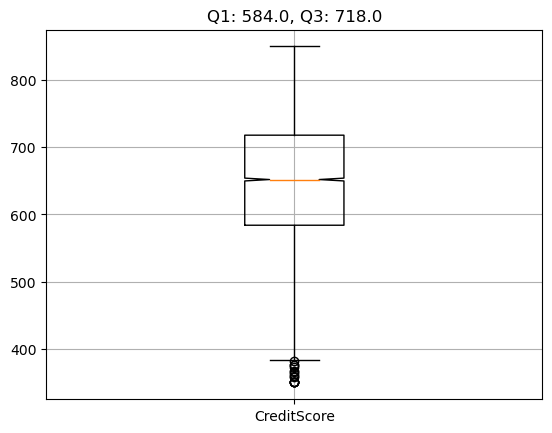

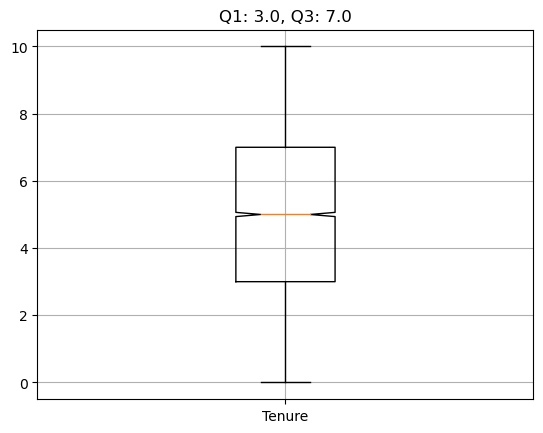

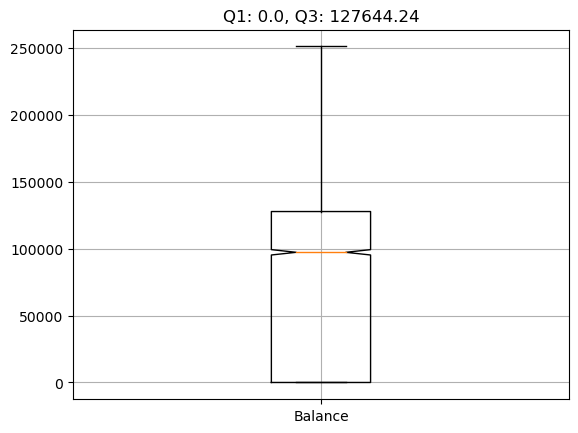

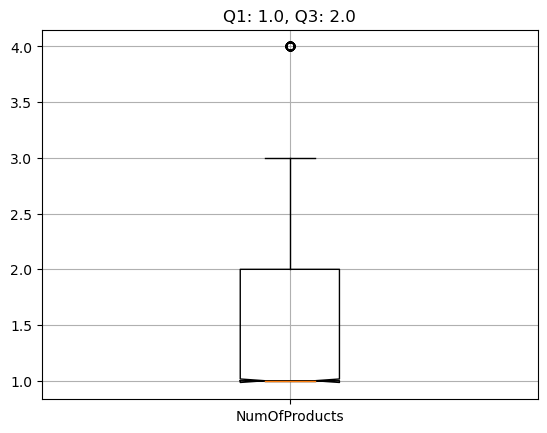

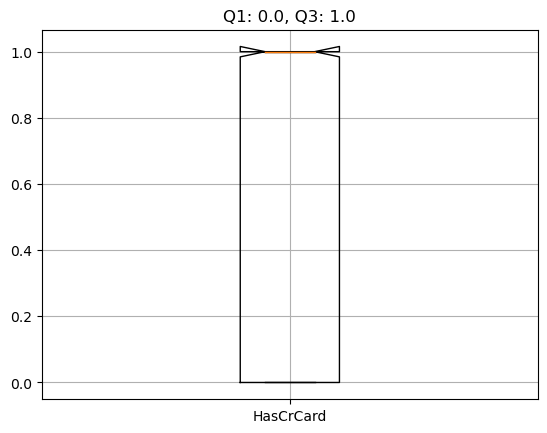

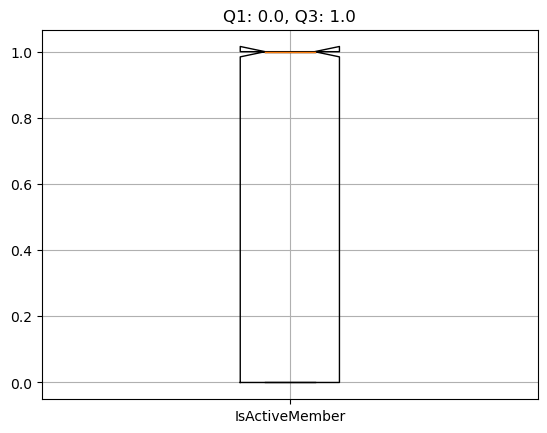

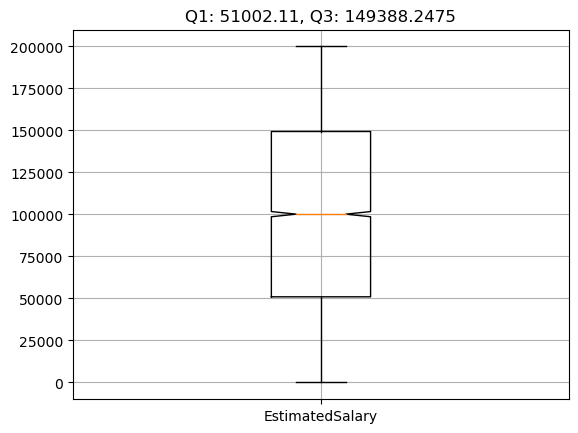

In [357]:
# Create a box-and-whisker plot for int columns
for i in range(len(num_cols)):
    num_col = num_cols[i]
    plt_data = df[num_col]
    fig, ax = plt.subplots()
    boxplt = ax.boxplot(plt_data, labels=[num_col], showfliers=True, showcaps=True, notch=True, widths=0.2)
    # print the 1st and 3rd quartile
    iqrs = [item.get_ydata() for item in boxplt['whiskers']]
    ax.set_title(f'Q1: {iqrs[:2][0][0]}, Q3: {iqrs[:2][1][0]}')
    ax.grid()
    # Save the figure.
    # plt.savefig(f'./Data/{num_col}_boxplot.png', bbox_inches='tight', facecolor='w')
    # Show Figure
    plt.show()

In [358]:
# Create clean DataFrame
clean_df = df.copy()
# remove fliers in CreditScore
num_col = 'CreditScore'
clean_df = clean_df[clean_df[num_col] < 850]

clean_lt2sigma_df = df.copy()
# remove fliers in CreditScore
num_col = 'CreditScore'
stddev = clean_lt2sigma_df[num_col].std()
clean_lt2sigma_df = clean_lt2sigma_df[np.abs((clean_lt2sigma_df[num_col] - clean_lt2sigma_df[num_col].mean())) <= (2*stddev)]
# # remove fliers in Age
# num_col = 'Age'
# stddev = clean_lt2sigma_df[num_col].std()
# clean_lt2sigma_df = clean_lt2sigma_df[np.abs((clean_lt2sigma_df[num_col] - clean_lt2sigma_df[num_col].mean())) <= (3*stddev)]
# # clean_lt2sigma_df = clean_lt2sigma_df.groupby([num_col]).filter(lambda a: len(a) > 1)

clean_df.describe()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000,9767.000000
mean,645.770247,5.017406,76432.616715,1.530562,0.705641,0.514283,100189.740593,0.204157
std,92.697374,2.893018,62420.084772,0.581881,0.455777,0.499822,57400.315001,0.403105
min,350.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,582.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51326.965000,0.000000
50%,649.000000,5.000000,97092.870000,1.000000,1.000000,1.000000,100403.050000,0.000000
75%,712.000000,8.000000,127661.075000,2.000000,1.000000,1.000000,149191.925000,0.000000
max,849.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [359]:
clean_lt2sigma_df.describe()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000
mean,650.207579,5.015158,76433.353309,1.531368,0.705053,0.515579,100028.174805,0.201789
std,86.710922,2.894281,62426.713554,0.580380,0.456043,0.499784,57432.210790,0.401357
min,458.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,587.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50895.310000,0.000000
50%,651.000000,5.000000,97070.055000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,713.000000,8.000000,127644.240000,2.000000,1.000000,1.000000,148990.230000,0.000000
max,843.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [360]:
# Saving the clean_df to csv
file_path = "./Resources/Churn_Modelling_main.csv"
df.to_csv(file_path, index=False)

In [361]:
# Saving the clean_df to csv
file_path = "./Resources/Churn_Modelling_cs_lt850.csv"
clean_df.to_csv(file_path, index=False)

In [362]:
# Saving the clean_df to csv
file_path = "./Resources/Churn_Modelling_cs_lt2sigma.csv"
clean_lt2sigma_df.to_csv(file_path, index=False)

## Build, Train, Test, and Assemble the Models
### Learning without removing outliers (original DataFrame: df or main_df)

In [363]:
# Create our features (after dropping our target)
target = ['Exited']
X = df.drop(target, axis=1)
str_cols = X.select_dtypes(include=['object']).columns
# Binary encoding using Pandas (multiple object columns)
X = pd.get_dummies(X, columns=str_cols, dtype='int')

# Create our target
y = df[target]

# Check a OneHotEncoder instance
print(X.shape)
X[0:10]

(10000, 18)


,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,AgeGroup_18-28,AgeGroup_28-38,AgeGroup_38-48,AgeGroup_48-58,AgeGroup_58-68,AgeGroup_68-92
0,619,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,0,1,0,0,0
1,608,1,83807.86,1,0,1,112542.58,0,0,1,1,0,0,0,1,0,0,0
2,502,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,0,1,0,0,0
3,699,1,0.00,2,0,0,93826.63,1,0,0,1,0,0,0,1,0,0,0
4,850,2,125510.82,1,1,1,79084.10,0,0,1,1,0,0,0,1,0,0,0
5,645,8,113755.78,2,1,0,149756.71,0,0,1,0,1,0,0,1,0,0,0
6,822,7,0.00,2,1,1,10062.80,1,0,0,0,1,0,0,0,1,0,0
7,376,4,115046.74,4,1,0,119346.88,0,1,0,1,0,0,1,0,0,0,0
8,501,4,142051.07,2,0,1,74940.50,1,0,0,0,1,0,0,1,0,0,0
9,684,2,134603.88,1,1,1,71725.73,1,0,0,0,1,1,0,0,0,0,0


In [364]:
# Check the balance of our target values
y.value_counts()

Exited
0         7963
1         2037
dtype: int64

In [365]:
# Set seed number to 1 for each model
seedn = 1
testsize = 0.25
nen = 100  # n_estimators number
# Split data into training and testing and check the balance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedn, test_size=testsize)
print(f'Train size: {y_train.value_counts()}\nTest size: {y_test.value_counts()}')

Train size: Exited
0         5983
1         1517
dtype: int64
Test size: Exited
0         1980
1          520
dtype: int64


In [366]:
# Reusable func to get the balanced accuracy score, confusion matrix, imbalanced clf report
def sum_func(lm, Xtest=X_test, ytest=y_test):
    # Making predictions using the testing data.
    y_pred = lm.predict(Xtest)
    # Calculate the balanced accuracy score
    bacc_score = balanced_accuracy_score(ytest, y_pred)
    # Calculate the confusion matrix
    cm = confusion_matrix(ytest, y_pred)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0 (Exited=0)", "Actual 1 (Exited=1)"], columns=["Predicted 0 (Negative)", "Predicted 1 (Positive)"]
    )
    # Summarize the imbalanced classification report
    iclf_report = classification_report_imbalanced(ytest, y_pred)

    # Print the balanced accuracy score
    print("Balanced Accuracy Score: %.6f" % bacc_score)
    # Print the confusion matrix
    print(f'Confusion Matrix:\n{cm_df}\n')
    # Print the imbalanced classification report
    print(f'Imbalanced Classification Report:\n{iclf_report}')

In [367]:
# Reusable func to plot the precision-recall curve
def plt_prerec(lm, model, Xtest=X_test, ytest=y_test):
    display = PrecisionRecallDisplay.from_estimator(lm, Xtest, ytest, name=model)
    _ = display.ax_.set_title(f'{model} Precision-Recall curve')

In [368]:
# Set up ensemble learning models
# RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=nen, random_state=seedn)
# BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=nen, random_state=seedn)
# EasyEnsembleClassifier
ee_model = EasyEnsembleClassifier(n_estimators=nen, random_state=seedn)
# Train the AdaBoostClassifier
ab_model = AdaBoostClassifier(n_estimators=nen, random_state=seedn)

### Over/Undersampling Combination: SMOTEENN

In [369]:
# Resample the training data with SMOTEENN
smote_enn = SMOTEENN(random_state=seedn)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print(y_resampled.value_counts())

Exited
1         2783
0         2170
dtype: int64


### Ensemble Learners: RandomForestClassifier with SMOTEENN

In [289]:
# Fitting the model
rfc = rfc_model.fit(X_resampled, y_resampled)

# Recalculate the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(rfc, X_test, y_test)

Balanced Accuracy Score: 0.720173
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1820                     160
Actual 1 (Exited=1)                     249                     271

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.92      0.52      0.90      0.69      0.50      1980
          1       0.63      0.52      0.92      0.57      0.69      0.46       520

avg / total       0.83      0.84      0.60      0.83      0.69      0.49      2500



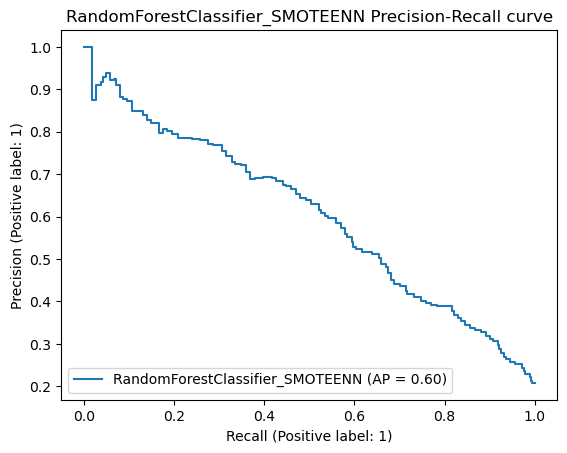

In [290]:
plt_prerec(rfc, 'RandomForestClassifier_SMOTEENN', X_test, y_test)

### Ensemble Learners: Balanced Random Forest Classifier with SMOTEENN

In [291]:
# Fitting the model
brfc = brf_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(brfc, X_test, y_test)

Balanced Accuracy Score: 0.698699
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1853                     127
Actual 1 (Exited=1)                     280                     240

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.94      0.46      0.90      0.66      0.45      1980
          1       0.65      0.46      0.94      0.54      0.66      0.41       520

avg / total       0.82      0.84      0.56      0.83      0.66      0.44      2500



In [292]:
# List the features sorted in descending order by feature importance
importances = brfc.feature_importances_

# Display feature importance as a DataFrame
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=True)

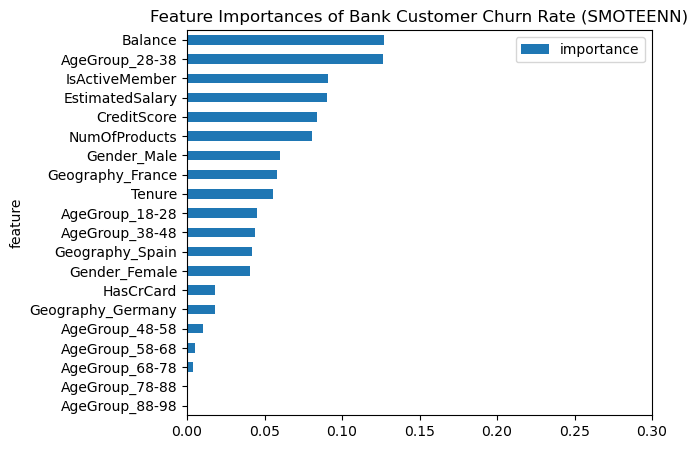

In [293]:
# Plot feature importances
fig = importance_df.plot.barh(x='feature', y='importance', title="Feature Importances of Bank Customer Churn Rate (SMOTEENN)", \
    xlim=(0, 0.30), figsize=(6, 5)).get_figure()
# Save the figure.
fig.savefig('Data/BankCustomerChurn_SMOTEENN_FeatureImportance.png', bbox_inches='tight', facecolor='w')

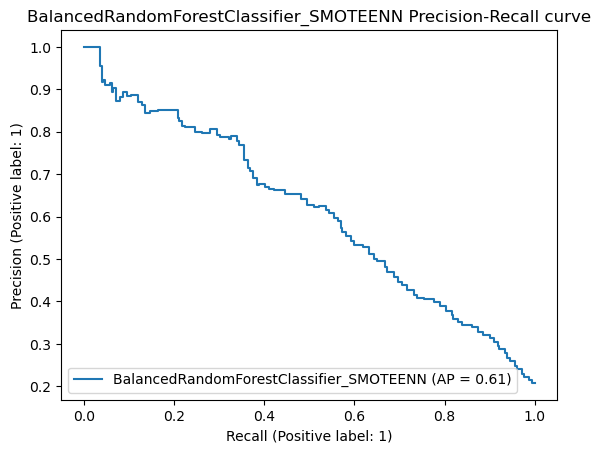

In [294]:
plt_prerec(brfc, 'BalancedRandomForestClassifier_SMOTEENN', X_test, y_test)

### Ensemble Learners: Easy Ensemble AdaBoost Classifier with SMOTEENN

In [295]:
# Fitting the model
eec = ee_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(eec, X_test, y_test)

Balanced Accuracy Score: 0.702613
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1819                     161
Actual 1 (Exited=1)                     267                     253

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.92      0.49      0.89      0.67      0.47      1980
          1       0.61      0.49      0.92      0.54      0.67      0.43       520

avg / total       0.82      0.83      0.58      0.82      0.67      0.46      2500



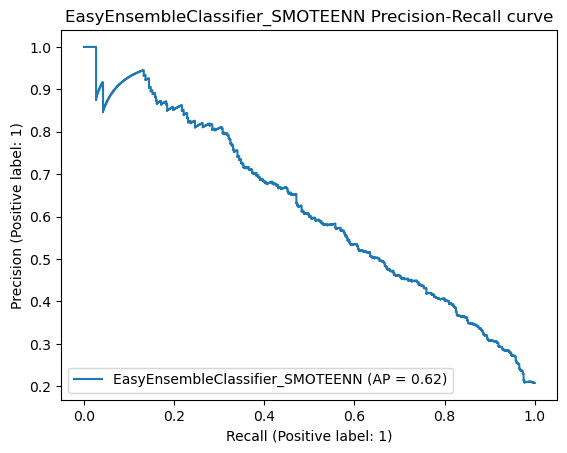

In [296]:
plt_prerec(eec, 'EasyEnsembleClassifier_SMOTEENN', X_test, y_test)

### Ensemble Learners: AdaBoost Classifier with SMOTEENN

In [297]:
# Fitting the model
abc = ab_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(abc, X_test, y_test)

Balanced Accuracy Score: 0.718211
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1797                     183
Actual 1 (Exited=1)                     245                     275

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.91      0.53      0.89      0.69      0.50      1980
          1       0.60      0.53      0.91      0.56      0.69      0.46       520

avg / total       0.82      0.83      0.61      0.82      0.69      0.49      2500



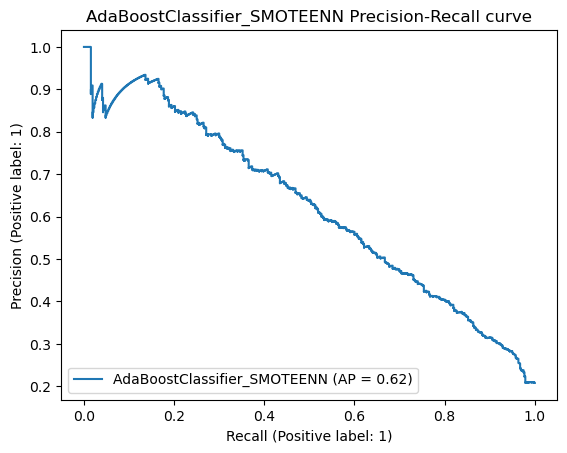

In [298]:
plt_prerec(abc, 'AdaBoostClassifier_SMOTEENN', X_test, y_test)

### Ensemble Learners: RandomForestClassifier

In [370]:
# Fitting the model
rfc = rfc_model.fit(X_train, y_train)

# Recalculate the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(rfc, X_test, y_test)

Balanced Accuracy Score: 0.712034
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1902                      78
Actual 1 (Exited=1)                     279                     241

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.96      0.46      0.91      0.67      0.47      1980
          1       0.76      0.46      0.96      0.57      0.67      0.42       520

avg / total       0.85      0.86      0.57      0.84      0.67      0.46      2500



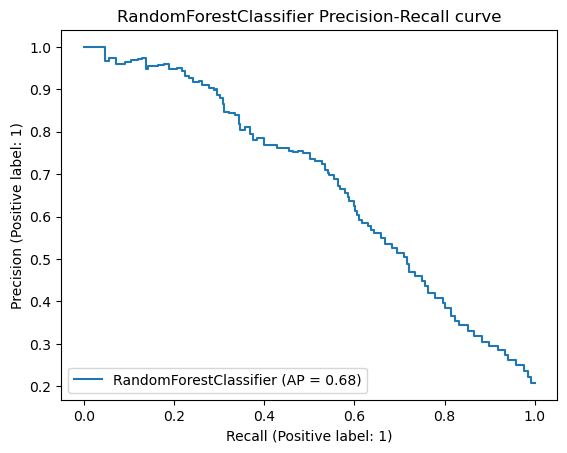

In [371]:
plt_prerec(rfc, 'RandomForestClassifier', X_test, y_test)

### Ensemble Learners: Balanced Random Forest Classifier

In [372]:
# Fitting the model
brfc = brf_model.fit(X_train, y_train)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(brfc, X_test, y_test)

Balanced Accuracy Score: 0.760635
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1569                     411
Actual 1 (Exited=1)                     141                     379

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.79      0.73      0.85      0.76      0.58      1980
          1       0.48      0.73      0.79      0.58      0.76      0.57       520

avg / total       0.83      0.78      0.74      0.79      0.76      0.58      2500



In [335]:
# List the features sorted in descending order by feature importance
importances = brfc.feature_importances_

# Display feature importance as a DataFrame
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=True)

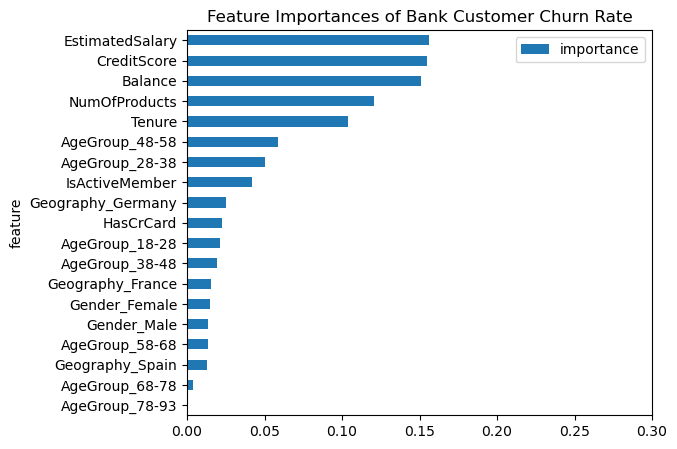

In [336]:
# Plot feature importances
fig = importance_df.plot.barh(x='feature', y='importance', title="Feature Importances of Bank Customer Churn Rate", \
    xlim=(0, 0.30), figsize=(6, 5)).get_figure()
# Save the figure.
fig.savefig('Data/BankCustomerChurn_FeatureImportance.png', bbox_inches='tight', facecolor='w')

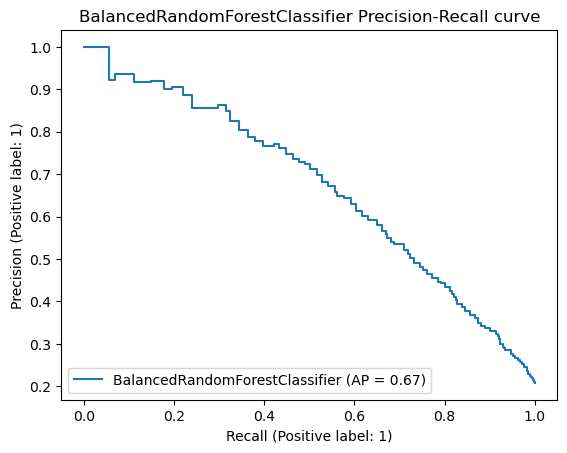

In [337]:
plt_prerec(brfc, 'BalancedRandomForestClassifier', X_test, y_test)

### Ensemble Learners: Easy Ensemble AdaBoost Classifier

In [338]:
# Fitting the model
eec = ee_model.fit(X_train, y_train)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(eec, X_test, y_test)

Balanced Accuracy Score: 0.767366
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1569                     411
Actual 1 (Exited=1)                     134                     386

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.79      0.74      0.85      0.77      0.59      1980
          1       0.48      0.74      0.79      0.59      0.77      0.59       520

avg / total       0.83      0.78      0.75      0.80      0.77      0.59      2500



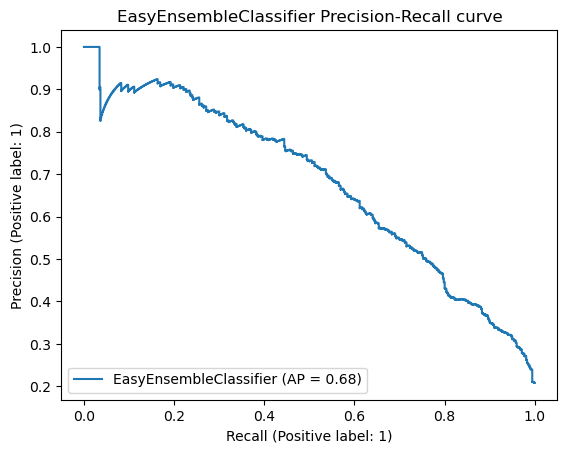

In [109]:
plt_prerec(eec, 'EasyEnsembleClassifier', X_test, y_test)

### Ensemble Learners: AdaBoost Classifier

In [110]:
# Fitting the model
abc = ab_model.fit(X, y)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(abc, X_test, y_test)

Balanced Accuracy Score: 0.729186
Confusion Matrix:
                     Predicted 0  Predicted 1
Actual 0 (Exited=0)         1909           71
Actual 1 (Exited=1)          263          257

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.96      0.49      0.92      0.69      0.50      1980
          1       0.78      0.49      0.96      0.61      0.69      0.45       520

avg / total       0.86      0.87      0.59      0.85      0.69      0.49      2500



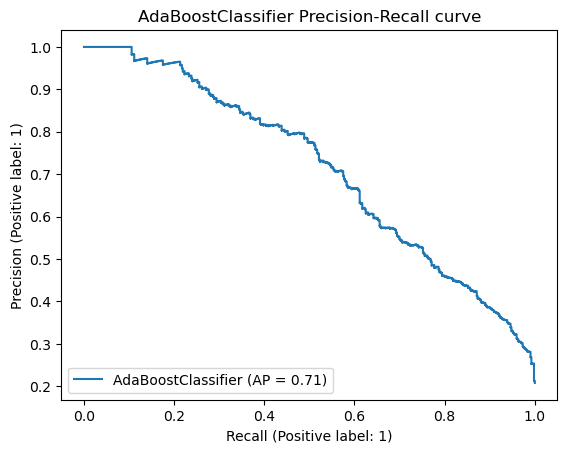

In [111]:
plt_prerec(abc, 'AdaBoostClassifier', X_test, y_test)

### Learning after removing outliers (DataFrame: clean_df)

In [373]:
# Create our features (after dropping our target)
target = ['Exited']
X = clean_df.drop(target, axis=1)
str_cols = X.select_dtypes(include=['object']).columns
# Binary encoding using Pandas (multiple object columns)
X = pd.get_dummies(X, columns=str_cols, dtype='int')

# Create our target
y = clean_df[target]

# Check a OneHotEncoder instance
print(X.shape)
X[0:10]

(9767, 18)


,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,AgeGroup_18-28,AgeGroup_28-38,AgeGroup_38-48,AgeGroup_48-58,AgeGroup_58-68,AgeGroup_68-92
0,619,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,0,1,0,0,0
1,608,1,83807.86,1,0,1,112542.58,0,0,1,1,0,0,0,1,0,0,0
2,502,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,0,1,0,0,0
3,699,1,0.00,2,0,0,93826.63,1,0,0,1,0,0,0,1,0,0,0
5,645,8,113755.78,2,1,0,149756.71,0,0,1,0,1,0,0,1,0,0,0
6,822,7,0.00,2,1,1,10062.80,1,0,0,0,1,0,0,0,1,0,0
7,376,4,115046.74,4,1,0,119346.88,0,1,0,1,0,0,1,0,0,0,0
8,501,4,142051.07,2,0,1,74940.50,1,0,0,0,1,0,0,1,0,0,0
9,684,2,134603.88,1,1,1,71725.73,1,0,0,0,1,1,0,0,0,0,0
10,528,6,102016.72,2,0,0,80181.12,1,0,0,0,1,0,1,0,0,0,0


In [374]:
# Check the balance of our target values
y.value_counts()

Exited
0         7773
1         1994
dtype: int64

In [375]:
# Split data into training and testing and check the balance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedn, test_size=testsize)
print(f'Train size: {y_train.value_counts()}\nTest size: {y_test.value_counts()}')

Train size: Exited
0         5809
1         1516
dtype: int64
Test size: Exited
0         1964
1          478
dtype: int64


### Over/Undersampling Combination: SMOTEENN

In [376]:
# Resample the training data with SMOTEENN
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print(y_resampled.value_counts())

Exited
1         2508
0         2011
dtype: int64


### Ensemble Learners: RandomForestClassifier with SMOTEENN

In [377]:
# Fitting the model
rfc = rfc_model.fit(X_resampled, y_resampled)

# Recalculate the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(rfc, X_test, y_test)

Balanced Accuracy Score: 0.717862
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1809                     155
Actual 1 (Exited=1)                     232                     246

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.92      0.51      0.90      0.69      0.49      1964
          1       0.61      0.51      0.92      0.56      0.69      0.45       478

avg / total       0.83      0.84      0.59      0.84      0.69      0.49      2442



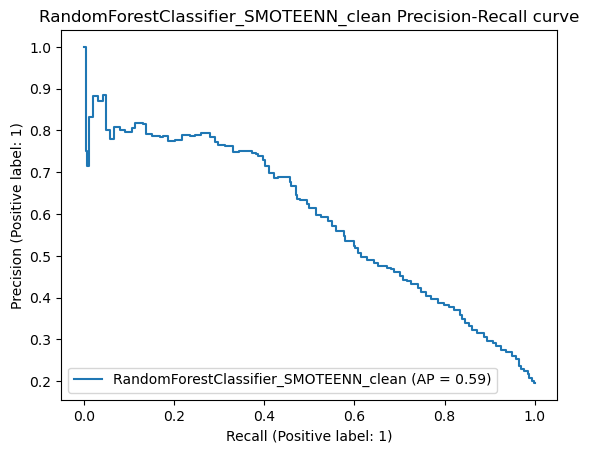

In [378]:
plt_prerec(rfc, 'RandomForestClassifier_SMOTEENN_clean', X_test, y_test)

### Ensemble Learners: Balanced Random Forest Classifier with SMOTEENN

In [123]:
# Fitting the model
brfc = brf_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(brfc, X_test, y_test)

Balanced Accuracy Score: 0.738949
Confusion Matrix:
                     Predicted 0  Predicted 1
Actual 0 (Exited=0)         1785          179
Actual 1 (Exited=1)          206          272

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.91      0.57      0.90      0.72      0.53      1964
          1       0.60      0.57      0.91      0.59      0.72      0.50       478

avg / total       0.84      0.84      0.64      0.84      0.72      0.53      2442



In [124]:
# List the features sorted in descending order by feature importance
importances = brfc.feature_importances_

# Display feature importance as a DataFrame
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=True)

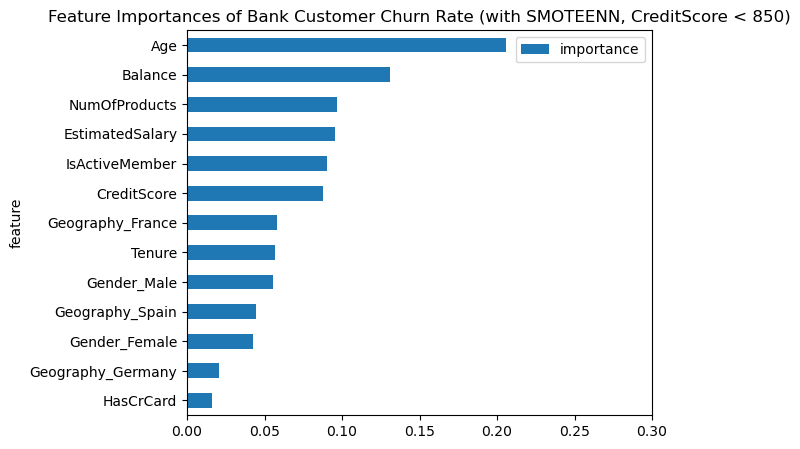

In [126]:
# Plot feature importances
fig = importance_df.plot.barh(x='feature', y='importance', title="Feature Importances of Bank Customer Churn Rate (SMOTEENN & CreditScore < 850)", \
    xlim=(0, 0.30), figsize=(6, 5)).get_figure()
# Save the figure.
fig.savefig('Data/BankCustomerChurn_SMOTEENN_clean_df_FeatureImportance.png', bbox_inches='tight', facecolor='w')

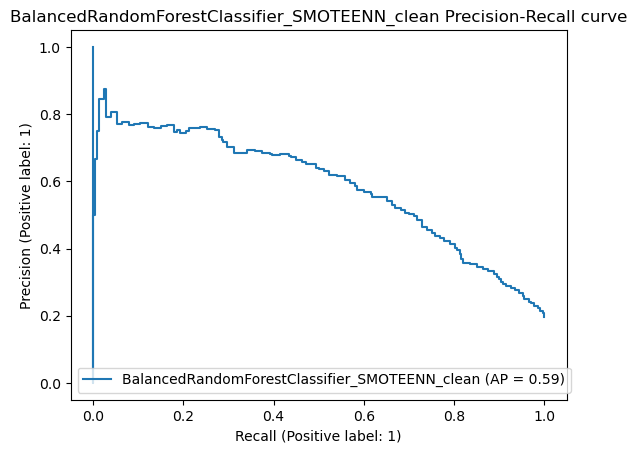

In [127]:
plt_prerec(brfc, 'BalancedRandomForestClassifier_SMOTEENN_clean', X_test, y_test)

### Ensemble Learners: Easy Ensemble AdaBoost Classifier with SMOTEENN

In [128]:
# Fitting the model
eec = ee_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(eec, X_test, y_test)

Balanced Accuracy Score: 0.741146
Confusion Matrix:
                     Predicted 0  Predicted 1
Actual 0 (Exited=0)         1732          232
Actual 1 (Exited=1)          191          287

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.88      0.60      0.89      0.73      0.54      1964
          1       0.55      0.60      0.88      0.58      0.73      0.51       478

avg / total       0.83      0.83      0.66      0.83      0.73      0.54      2442



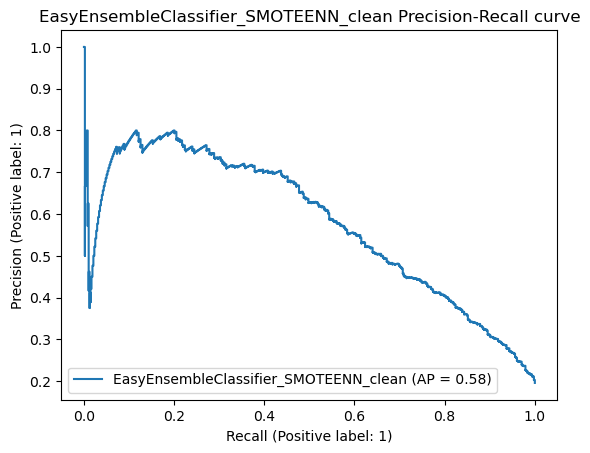

In [129]:
plt_prerec(eec, 'EasyEnsembleClassifier_SMOTEENN_clean', X_test, y_test)

### Ensemble Learners: AdaBoost Classifier with SMOTEENN

In [130]:
# Fitting the model
abc = ab_model.fit(X_resampled, y_resampled)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(abc, X_test, y_test)

Balanced Accuracy Score: 0.753748
Confusion Matrix:
                     Predicted 0  Predicted 1
Actual 0 (Exited=0)         1687          277
Actual 1 (Exited=1)          168          310

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.86      0.65      0.88      0.75      0.57      1964
          1       0.53      0.65      0.86      0.58      0.75      0.55       478

avg / total       0.83      0.82      0.69      0.82      0.75      0.56      2442



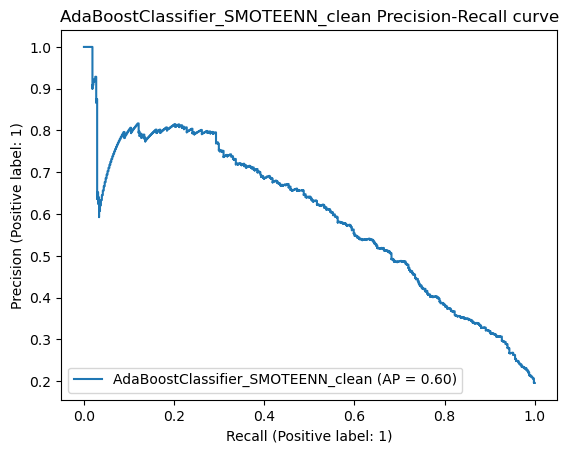

In [131]:
plt_prerec(abc, 'AdaBoostClassifier_SMOTEENN_clean', X_test, y_test)

### Ensemble Learners: RandomForestClassifier

In [379]:
# Fitting the model
rfc = rfc_model.fit(X_train, y_train)

# Recalculate the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(rfc, X_test, y_test)

Balanced Accuracy Score: 0.696443
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1881                      83
Actual 1 (Exited=1)                     270                     208

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.96      0.44      0.91      0.65      0.44      1964
          1       0.71      0.44      0.96      0.54      0.65      0.39       478

avg / total       0.84      0.86      0.54      0.84      0.65      0.43      2442



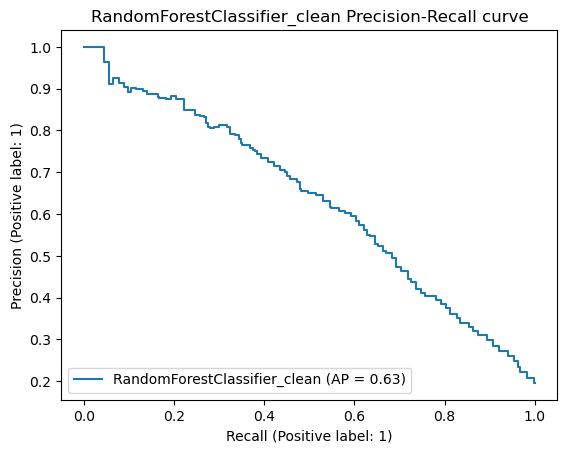

In [380]:
plt_prerec(rfc, 'RandomForestClassifier_clean', X_test, y_test)

### Ensemble Learners: Balanced Random Forest Classifier

In [381]:
# Fitting the model
brfc = brf_model.fit(X_train, y_train)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(brfc, X_test, y_test)

Balanced Accuracy Score: 0.762267
Confusion Matrix:
                     Predicted 0 (Negative)  Predicted 1 (Positive)
Actual 0 (Exited=0)                    1552                     412
Actual 1 (Exited=1)                     127                     351

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.79      0.73      0.85      0.76      0.58      1964
          1       0.46      0.73      0.79      0.57      0.76      0.58       478

avg / total       0.83      0.78      0.75      0.80      0.76      0.58      2442



In [135]:
# List the features sorted in descending order by feature importance
importances = brfc.feature_importances_

# Display feature importance as a DataFrame
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=True)

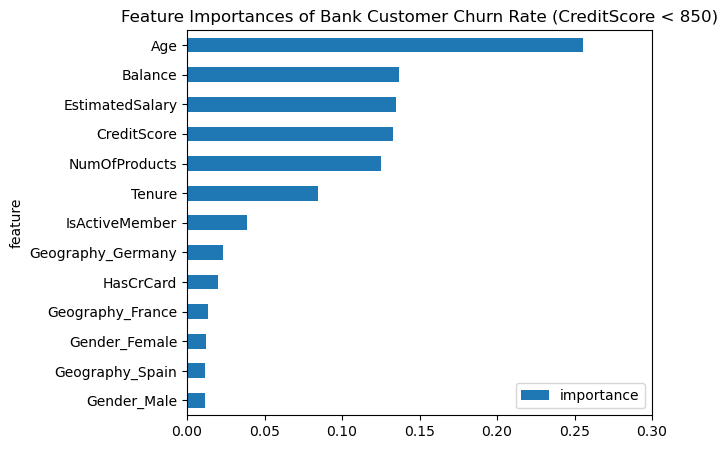

In [138]:
# Plot feature importances
fig = importance_df.plot.barh(x='feature', y='importance', title="Feature Importances of Bank Customer Churn Rate (CreditScore < 850)", \
    xlim=(0, 0.30), figsize=(6, 5)).get_figure()
# Save the figure.
fig.savefig('Data/BankCustomerChurn_clean_df_FeatureImportance.png', bbox_inches='tight', facecolor='w')

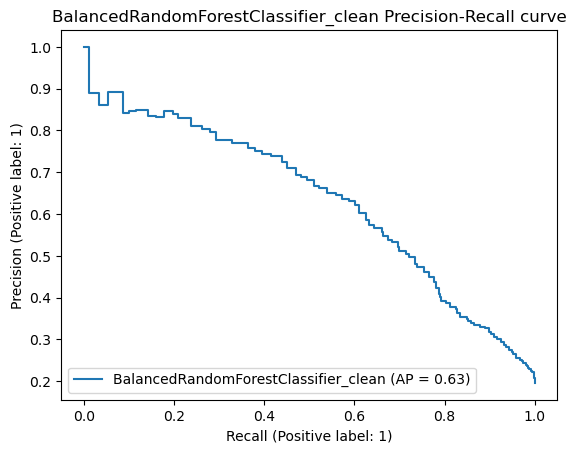

In [139]:
plt_prerec(brfc, 'BalancedRandomForestClassifier_clean', X_test, y_test)

### Ensemble Learners: Easy Ensemble AdaBoost Classifier

In [140]:
# Fitting the model
eec = ee_model.fit(X_train, y_train)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(eec, X_test, y_test)

Balanced Accuracy Score: 0.771172
Confusion Matrix:
                     Predicted 0  Predicted 1
Actual 0 (Exited=0)         1550          414
Actual 1 (Exited=1)          118          360

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.75      0.85      0.77      0.60      1964
          1       0.47      0.75      0.79      0.58      0.77      0.59       478

avg / total       0.84      0.78      0.76      0.80      0.77      0.60      2442



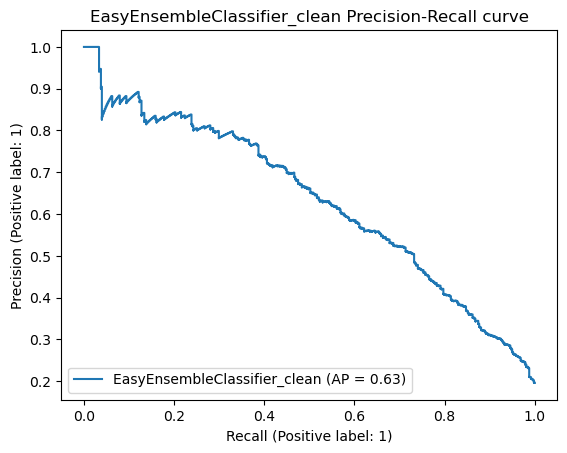

In [141]:
plt_prerec(eec, 'EasyEnsembleClassifier_clean', X_test, y_test)

### Ensemble Learners: AdaBoost Classifier

In [533]:
# Fitting the model
abc = ab_model.fit(X, y)

# Calculated the balanced accuracy score, confusion matrix, imbalanced clf report
sum_func(ab_model, X_test, y_test)

Balanced Accuracy Score: 0.717214


array([[2464,  119],
       [ 333,  308]], dtype=int64)

,Predicted 0,Predicted 1
Actual 0 (Exited=0),2464,119
Actual 1 (Exited=1),333,308


                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.95      0.48      0.92      0.68      0.48      2583
          1       0.72      0.48      0.95      0.58      0.68      0.44       641

avg / total       0.85      0.86      0.57      0.85      0.68      0.47      3224



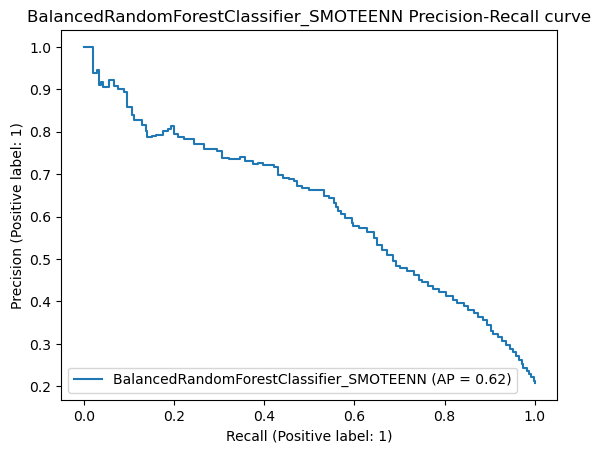

In [ ]:
plt_prerec(abc, 'AdaBoostClassifier_clean', X_test, y_test)

### PostgreSQL Database Management from/to Python

In [534]:
# SQLAlchemy: Establish connection to postgresql
username='postgres'
pwd=pga_pass
dbase='churnmodel_db'
hostname='localhost'
port_id=5432
engine = create_engine(f"postgresql://{username}:{pwd}@{hostname}:{port_id}/{dbase}")

try:
    engine.connect()
    print(f'Connection to PostgreSQL db called {dbase} is successfully established!\n')
except Exception as error:
    print(error)

Connection to PostgreSQL db called churnmodel_db is successfully established!



In [535]:
# Create tables called main_df in postgresql (PS: remove if_exists)
df.to_sql(name='main_df', con=engine, index=False, if_exists='replace')

1000

In [536]:
# Retrieve data from postgresql
pd.read_sql("SELECT * FROM main_df;", con=engine)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [537]:
# single column query results
query = 'SELECT "CreditScore" FROM main_df;'
scores = engine.execute(query)
pd.DataFrame(scores).head(10)

,CreditScore
0,619
1,608
2,502
3,699
4,850
5,645
6,822
7,376
8,501
9,684


In [538]:
age_limit = 70
query = f'SELECT * FROM main_df WHERE "Age" > {age_limit} AND "Exited" = 1;'
ages = engine.execute(query)
pd.DataFrame(ages)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,523,France,Female,73,7,0.00,2,0,0,130883.90,1
1,727,Spain,Male,71,8,0.00,1,1,1,198446.91,1
2,546,Germany,Female,74,8,114888.74,2,1,1,66732.63,1
3,779,France,Male,71,3,0.00,2,1,1,146895.36,1
4,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
5,667,Spain,Male,71,4,137260.78,1,0,1,94433.08,1
6,576,Germany,Female,71,6,140273.47,1,1,1,193135.25,1
7,624,France,Female,71,4,170252.05,3,1,1,73679.59,1
8,609,Germany,Female,71,6,113317.10,1,1,0,108258.22,1
9,782,Germany,Female,72,5,148666.99,1,1,0,2605.65,1


In [117]:
# group by Age and order by Exited counts
query = 'SELECT "Age", "Exited", COUNT("Exited") FROM main_df WHERE "Exited" = 1 GROUP BY "Age", "Exited" ORDER BY COUNT DESC;'
ages = engine.execute(query)
pd.DataFrame(ages)

,Age,Exited,count
0,46,1,91
1,40,1,89
2,43,1,88
3,45,1,87
4,48,1,80
5,47,1,77
6,42,1,77
7,49,1,75
8,44,1,73
9,39,1,72


In [118]:
# group by Age and order by Exited counts
query = 'SELECT "Age", "Exited", COUNT("Exited") FROM main_df WHERE "Exited" = 0 GROUP BY "Age", "Exited" ORDER BY COUNT DESC;'
ages = engine.execute(query)
pd.DataFrame(ages)

,Age,Exited,count
0,35,0,417
1,37,0,416
2,34,0,414
3,38,0,414
4,36,0,403
...,...,...,...
65,83,0,1
66,88,0,1
67,85,0,1
68,84,0,1


In [119]:
# Create tables called clean_df in postgresql (PS: remove if_exists)
clean_df.to_sql(name='clean_df', con=engine, index=False, if_exists='replace')

767

In [120]:
# Retrieve data from postgresql
pd.read_sql("SELECT * FROM clean_df;", con=engine)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9762,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9763,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9764,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9765,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [121]:
# single column query results
query = 'SELECT "CreditScore" FROM clean_df;'
scores = engine.execute(query)
pd.DataFrame(scores).head(10)

,CreditScore
0,619
1,608
2,502
3,699
4,645
5,822
6,376
7,501
8,684
9,528


In [122]:
age_limit = 70
query = f'SELECT * FROM clean_df WHERE "Age" > {age_limit} AND "Exited" = 1;'
ages = engine.execute(query)
pd.DataFrame(ages)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,523,France,Female,73,7,0.00,2,0,0,130883.90,1
1,727,Spain,Male,71,8,0.00,1,1,1,198446.91,1
2,546,Germany,Female,74,8,114888.74,2,1,1,66732.63,1
3,779,France,Male,71,3,0.00,2,1,1,146895.36,1
4,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
5,667,Spain,Male,71,4,137260.78,1,0,1,94433.08,1
6,576,Germany,Female,71,6,140273.47,1,1,1,193135.25,1
7,624,France,Female,71,4,170252.05,3,1,1,73679.59,1
8,609,Germany,Female,71,6,113317.10,1,1,0,108258.22,1
9,782,Germany,Female,72,5,148666.99,1,1,0,2605.65,1


In [123]:
# group by Age and order by Exited counts
query = 'SELECT "Age", "Exited", COUNT("Exited") FROM clean_df WHERE "Exited" = 1 GROUP BY "Age", "Exited" ORDER BY COUNT DESC;'
ages = engine.execute(query)
pd.DataFrame(ages)

,Age,Exited,count
0,46,1,91
1,40,1,87
2,43,1,87
3,45,1,83
4,48,1,79
5,47,1,75
6,42,1,74
7,44,1,72
8,49,1,72
9,50,1,71


In [124]:
# group by Age and order by Exited counts
query = 'SELECT "Age", "Exited", COUNT("Exited") FROM clean_df WHERE "Exited" = 0 GROUP BY "Age", "Exited" ORDER BY COUNT DESC;'
ages = engine.execute(query)
pd.DataFrame(ages)

,Age,Exited,count
0,35,0,409
1,37,0,408
2,34,0,405
3,38,0,400
4,36,0,391
...,...,...,...
65,83,0,1
66,84,0,1
67,85,0,1
68,88,0,1


In [125]:
# group by Age and order by Exited counts
query = 'SELECT "CreditScore", "Exited", COUNT("Exited") FROM clean_df WHERE "Exited" = 1 GROUP BY "CreditScore", "Exited" ORDER BY COUNT DESC;'
scores = engine.execute(query)
pd.DataFrame(scores)

,CreditScore,Exited,count
0,651,1,17
1,705,1,16
2,637,1,14
3,678,1,13
4,625,1,13
...,...,...,...
414,838,1,1
415,457,1,1
416,373,1,1
417,832,1,1


In [126]:
# group by Age and order by Exited counts
query = 'SELECT "CreditScore", "Exited", COUNT("Exited") FROM clean_df WHERE "Exited" = 0 GROUP BY "CreditScore", "Exited" ORDER BY COUNT DESC;'
scores = engine.execute(query)
pd.DataFrame(scores)

,CreditScore,Exited,count
0,678,0,50
1,684,0,43
2,655,0,43
3,670,0,42
4,667,0,42
...,...,...,...
436,405,0,1
437,442,0,1
438,408,0,1
439,417,0,1


In [127]:
# Drop tables called stations and ridership in postgresql
# engine.execute("DROP TABLE clean_df CASCADE;")